# Analysis and Target Generator

## Table of Contents

*Jump to section of notebook by copying section heading into finder bar*


* **Part 0**
    * Section A: Dependencies
    * Section B: Import Data
* **Part 1: Find Coorelation Between shocks and economically improving areas**
    * Section 1.A: Organize Tracts into Counties
      * 1.A.i Broadband
      * 1.A.ii Economic Scores
      * 1.A.iii Merge County Economic Score and Broadband County Score
    * Section 1.B: See if Score Increases correlates to number of improving tracts
      * 1.B.i Initial Correlation Matrix
      * 1.B.ii New Correlation Matrix
* **Part 2: Characteristics of Successful Broadband and Internet Expenditure**
    * Section 2.A: Combining Data Sources
      * 2.A.i Demographic Selection
      * 2.A.ii Create Master Demographics Table
    * Section 2.B: Analyses
    * Section 2.C: Clusters of Related Variables
      * 2.C.i General Statistics
      * 2.C.ii Ethnicity statistics
      * 2.C.iii Place of Origin
      * 2.C.iv Education Level
      * 2.C.v Income and work style
      * 2.C.vi Employment statististics
      * 2.C.vii Professions
      * 2.C.viii Housing Data
    * Section 2.D: Total Results Between Categories of Tracts and Assorted Variables
* **Part 3: Equity Score Pairing**
    * Section 3.A: Preparing Broadband Indicators
    * Section 3.B: Find PCA Transform
    * Section 3.C: Connecting Scores to Geography
    * Section 3.D: Grouping by Density
    * Section 3.E: Finding Outliers by Race
    * Section 3.F: Finding additional important variables using regression
      * 3.F.i Linear Regression
      * 3.F.ii Lasso Regression
    * Section 3.G: Finding Local Spatial Autocorrelation
      * 3.G.i Defining and Finding spatial statistics
      * 3.G.ii Graphing LISA statisitics
      * 3.G.iii Appending to Data Frame
* **Part 4 Identify Target Counties** 

### Section 0.A: Dependencies

In [ ]:
pip install geopandas splot pysal shapely watermark

In [ ]:
import pandas as pd
import numpy as np
import geopandas as gpd
import seaborn as sb
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.api as sm
import plotly.graph_objects as go
import shapely
import splot
import pysal
from scipy.spatial.distance import cdist, pdist
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
from shapely import wkt
from splot import esda as esdaplot
from pysal.explore import esda   # Exploratory Spatial analytics
from pysal.lib import weights    # Spatial weights
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score


In [6]:
%reload_ext watermark
%watermark -iv -a 'Max Magid' -u -d -v

Author: Max Magid

Last updated: 2022-08-22

Python implementation: CPython
Python version       : 3.7.13
IPython version      : 7.9.0

sklearn    : 1.0.2
esda       : 2.4.3
seaborn    : 0.11.2
shapely    : 1.8.4
splot      : 1.1.5.post1
pysal      : 2.6.0
numpy      : 1.21.6
libpysal   : 4.6.2
pandas     : 1.3.5
geopandas  : 0.10.2
statsmodels: 0.12.2
matplotlib : 3.2.2
plotly     : 5.5.0



### Section 0.B: Import Data

In [ ]:
# Economic Analysis Datasets
econ3_15=pd.read_csv('processed data/econ_12_to_15.csv').iloc[:,1:]
econ3_16=pd.read_csv('processed data/econ_13_to_16.csv').iloc[:,1:]
econ3_17=pd.read_csv('processed data/econ_14_to_17.csv').iloc[:,1:]
econ3_18=pd.read_csv('processed data/econ_15_to_18.csv').iloc[:,1:]
econ3_19=pd.read_csv('processed data/econ_16_to_19.csv').iloc[:,1:]

In [ ]:
# Individual Broadband Indicators
census_bband19=pd.read_csv('processed data/bband_2019.csv').iloc[:,1:]
nanda_14_18=pd.read_csv('processed data/nanda_broadband_tract_2014-2018_01P.csv')
ibn=pd.read_csv('processed data/IBNTracts.csv')

In [ ]:
#Longitudinal broadband dataframe we created
bband=pd.read_csv('processed data/bband_score.csv').iloc[:,1:]

In [ ]:
# ACS Demographic data
acs12=pd.read_csv('processed data/acs_12_filled.csv').iloc[:,1:]
acs13=pd.read_csv('processed data/acs_13_filled.csv').iloc[:,1:]
acs14=pd.read_csv('processed data/acs_14_filled.csv').iloc[:,1:]
acs15=pd.read_csv('processed data/acs_15_filled.csv').iloc[:,1:]
acs16=pd.read_csv('processed data/acs_16_filled.csv').iloc[:,1:]
acs17=pd.read_csv('processed data/acs_17_filled.csv').iloc[:,1:]
acs18=pd.read_csv('processed data/acs_18_filled.csv').iloc[:,1:]
acs19=pd.read_csv('processed data/acs_19_filled.csv').iloc[:,1:]

In [ ]:
equity_df=pd.read_csv('processed data/acs_equity.csv').iloc[:,1:]

In [ ]:
# Matches name of county to its fips code
county_name=pd.read_csv('raw data/county_fips.csv')

## Part 1: Find Coorelation Between shocks and economically improving areas

### Section 1.A: Organize Tracts into Counties

#### 1.A.i Broadband

In [ ]:
#add year column to acs tables

acs12['year']=2012
acs13['year']=2013
acs14['year']=2014
acs15['year']=2015
acs16['year']=2016
acs17['year']=2017
acs18['year']=2018
acs19['year']=2019


In [ ]:
#concatenate separate sheets into one

pop=pd.concat([acs12[['GEOID_x','year','population']],
               acs13[['GEOID_x','year','population']],
               acs14[['GEOID_x','year','population']],
               acs15[['GEOID_x','year','population']],
               acs16[['GEOID_x','year','population']],
               acs17[['GEOID_x','year','population']],
               acs18[['GEOID_x','year','population']],
               acs19[['GEOID_x','year','population']]],axis=0)

In [ ]:
#merge with bband table on tract id and year

bband_p=pop.merge(bband,left_on=['GEOID_x','year'],right_on=['tract_fips','year'])

In [ ]:
#Group by county and include the average broadband score and the one from one year ago, two years ago,
#and three years ago

bband_county=bband_p.groupby(by=['year','state','county','countyname'],
                as_index=False).apply(lambda x: pd.Series(dict(
    nscore=(x.normalized_score*x.population).sum()/x.population.sum(),
    lag1_diff=(x.lag1_diff*x.population).sum()/x.population.sum(),
    lag2_diff=(x.lag2_diff*x.population).sum()/x.population.sum(),
    lag3_diff=(x.lag3_diff*x.population).sum()/x.population.sum())))

#### 1.A.ii Economic Scores

In [ ]:
# Create new columns from tract id for county and state ids for econ table spanning 2012 to 2015
# and assign year (for ending year)

e15_s=econ3_15[['GEOID_Data','GEOID_x','cluster_sorted']]
e15_s['year']=2015

county=[]
state=[]

for i in range(len(e15_s)):
  state.append(int(e15_s.GEOID_Data.iloc[i][7:9]))
  county.append(int(e15_s.GEOID_Data.iloc[i][9:12]))

e15_s['state'],e15_s['county'] = state,county

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [ ]:
# Create new columns from tract id for county and state ids for econ table spanning 2013 to 2016
# and assign year (for ending year)

e16_s=econ3_16[['GEOID_Data','GEOID_x','cluster_sorted']]
e16_s['year']=2016

county=[]
state=[]

for i in range(len(e16_s)):
  state.append(int(e16_s.GEOID_Data.iloc[i][7:9]))
  county.append(int(e16_s.GEOID_Data.iloc[i][9:12]))

e16_s['state'],e16_s['county']=state,county

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [ ]:
# Create new columns from tract id for county and state ids for econ table spanning 2014 to 2017
# and assign year (for ending year)

e17_s=econ3_17[['GEOID_Data','GEOID_x','cluster_sorted']]
e17_s['year']=2017

county=[]
state=[]

for i in range(len(e17_s)):
  state.append(int(e17_s.GEOID_Data.iloc[i][7:9]))
  county.append(int(e17_s.GEOID_Data.iloc[i][9:12]))

e17_s['state'],e17_s['county'] = state,county

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [ ]:
# Create new columns from tract id for county and state ids for econ table spanning 2015 to 2018
# and assign year (for ending year)

e18_s=econ3_18[['GEOID_Data','GEOID_x','cluster_sorted']]
e18_s['year']=2018

county=[]
state=[]

for i in range(len(e18_s)):
  state.append(int(e18_s.GEOID_Data.iloc[i][7:9]))
  county.append(int(e18_s.GEOID_Data.iloc[i][9:12]))

e18_s['state'],e18_s['county'] = state,county

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [ ]:
# Create new columns from tract id for county and state ids for econ table spanning 2016 to 2019
# and assign year (for ending year)

e19_s=econ3_19[['GEOID_Data','GEOID_x','cluster_sorted']]
e19_s['year']=2019

county=[]
state=[]

for i in range(len(e19_s)):
  state.append(int(e19_s.GEOID_Data.iloc[i][7:9]))
  county.append(int(e19_s.GEOID_Data.iloc[i][9:12]))

e19_s['state'],e19_s['county'] = state,county

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [ ]:
# Concatenate all of the economic analysis tables into one

e_s=pd.concat([e15_s[['year','state','county','cluster_sorted']],
           e16_s[['year','state','county','cluster_sorted']],
           e17_s[['year','state','county','cluster_sorted']],
           e18_s[['year','state','county','cluster_sorted']],
           e19_s[['year','state','county','cluster_sorted']]])

In [ ]:
# Group by counties and years, count number of tracts of each economic development type

e_counts=e_s.groupby(by=['year','state','county'],
                as_index=False).apply(lambda x: pd.Series(dict(
    count_1=(x.cluster_sorted==1).sum()/x.cluster_sorted.count(),
    count_2=(x.cluster_sorted==2).sum()/x.cluster_sorted.count(),
    count_3=(x.cluster_sorted==3).sum()/x.cluster_sorted.count(),
    count_4=(x.cluster_sorted==4).sum()/x.cluster_sorted.count(),
    count_5=(x.cluster_sorted==5).sum()/x.cluster_sorted.count())))

In [ ]:
# Display table as sanity check

e_counts

,year,state,county,count_1,count_2,count_3,count_4,count_5
0,2015,1,1,0.250000,0.0,0.583333,0.166667,0.0
1,2015,1,3,0.031250,0.0,0.906250,0.062500,0.0
2,2015,1,5,0.111111,0.0,0.666667,0.222222,0.0
3,2015,1,7,0.000000,0.0,1.000000,0.000000,0.0
4,2015,1,9,0.000000,0.0,0.777778,0.222222,0.0
...,...,...,...,...,...,...,...,...
16089,2019,72,145,0.142857,0.0,0.785714,0.071429,0.0
16090,2019,72,147,1.000000,0.0,0.000000,0.000000,0.0
16091,2019,72,149,0.833333,0.0,0.000000,0.166667,0.0
16092,2019,72,151,0.777778,0.0,0.111111,0.111111,0.0


#### 1.A.iii Merge County Economic Score and Broadband County Score

In [ ]:
# Merge county level economic and broadband tables together by year and county

econ_bband_c=bband_county.merge(e_counts,on=['year','state','county'])

In [ ]:
econ_bband_c.head()

,year,state,county,countyname,nscore,lag1_diff,lag2_diff,lag3_diff,count_1,count_2,count_3,count_4,count_5
0,2015,1,1,Autauga County,-0.050551,0.082902,0.211259,0.193268,0.250000,0.0,0.583333,0.166667,0.0
1,2015,1,3,Baldwin County,-0.674551,-0.046847,0.177980,-0.401227,0.031250,0.0,0.906250,0.062500,0.0
2,2015,1,5,Barbour County,-0.976793,0.229253,0.842425,0.266270,0.111111,0.0,0.666667,0.222222,0.0
3,2015,1,7,Bibb County,-1.708595,0.165534,0.333712,0.279561,0.000000,0.0,1.000000,0.000000,0.0
4,2015,1,9,Blount County,-1.530547,-0.008024,-0.150500,-0.457414,0.000000,0.0,0.777778,0.222222,0.0


### Section 1.B: See if Score Increases correlates to number of improving tracts

#### 1.B.i Initial Correlation Matrix

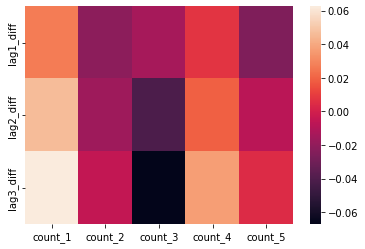

In [ ]:
# Find the correlation between the economic development group and the lag differences.
# white and black squares show stronger levels of correlation (negative or positive)

corrMatrix = econ_bband_c[['lag1_diff','lag2_diff','lag3_diff','count_1',
              'count_2','count_3','count_4','count_5']].corr().iloc[:3,3:]
sb.heatmap(corrMatrix, annot=False, fmt='g')
plt.show()

It looks like the difference between the year0 score, and year3 score (lag3_diff) has the most positive correlation with group 4 of economic change. This suggests that it takes a while after an economic shock for the effects to be made. Indeed, the lag1 correlation is negative, which tells me that the economic effects of lacking broadband are being felt because the benefits of gaining broadband haven't sunk in yet.

To test this theory I am going to compare the lags to years in the futue. (i.e. Broadband Change 2014 - 2015 Compared to Economic Change 2013-2016 instead of 2012-2015.)

#### 1.B.ii New Correlation Matrix

In [ ]:
# Add the lagged economic groupins to the dataset by changing the year column 
# and merging it back to the original dataset.

e_counts_plus1=e_counts.copy()
e_counts_plus1['year']=e_counts.year-1
e_counts_plus1=e_counts_plus1.rename(columns={'count_1':'fut1_1',
                                              'count_2':'fut1_2',
                                              'count_3':'fut1_3',
                                              'count_4':'fut1_4',
                                              'count_5':'fut1_5'})

e_counts_plus2=e_counts.copy()
e_counts_plus2['year']=e_counts.year-2
e_counts_plus2=e_counts_plus2.rename(columns={'count_1':'fut2_1',
                                              'count_2':'fut2_2',
                                              'count_3':'fut2_3',
                                              'count_4':'fut2_4',
                                              'count_5':'fut2_5'})

e_counts_plus3=e_counts.copy()
e_counts_plus3['year']=e_counts.year-3
e_counts_plus3=e_counts_plus3.rename(columns={'count_1':'fut3_1',
                                              'count_2':'fut3_2',
                                              'count_3':'fut3_3',
                                              'count_4':'fut3_4',
                                              'count_5':'fut3_5'})

e_counts_plus=e_counts.merge(e_counts_plus1,on=['year','county','state'],how='left')
e_counts_plus=e_counts_plus.merge(e_counts_plus2,on=['year','county','state'],how='left')
e_counts_plus=e_counts_plus.merge(e_counts_plus3,on=['year','county','state'],how='left')

e_counts_plus

,year,state,county,count_1,count_2,count_3,count_4,count_5,fut1_1,fut1_2,...,fut2_1,fut2_2,fut2_3,fut2_4,fut2_5,fut3_1,fut3_2,fut3_3,fut3_4,fut3_5
0,2015,1,1,0.250000,0.0,0.583333,0.166667,0.0,0.000000,0.0,...,0.000000,0.0,1.000000,0.000000,0.0,0.000000,0.00000,1.000000,0.000000,0.0
1,2015,1,3,0.031250,0.0,0.906250,0.062500,0.0,0.031250,0.0,...,0.000000,0.0,0.937500,0.062500,0.0,0.000000,0.03125,0.875000,0.093750,0.0
2,2015,1,5,0.111111,0.0,0.666667,0.222222,0.0,0.000000,0.0,...,0.777778,0.0,0.000000,0.222222,0.0,0.333333,0.00000,0.444444,0.222222,0.0
3,2015,1,7,0.000000,0.0,1.000000,0.000000,0.0,0.000000,0.0,...,0.000000,0.0,0.750000,0.250000,0.0,0.000000,0.00000,1.000000,0.000000,0.0
4,2015,1,9,0.000000,0.0,0.777778,0.222222,0.0,0.444444,0.0,...,0.555556,0.0,0.222222,0.222222,0.0,0.333333,0.00000,0.555556,0.111111,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16089,2019,72,145,0.142857,0.0,0.785714,0.071429,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16090,2019,72,147,1.000000,0.0,0.000000,0.000000,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16091,2019,72,149,0.833333,0.0,0.000000,0.166667,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16092,2019,72,151,0.777778,0.0,0.111111,0.111111,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Merge the adjusted econ scores back to the broadband county scores

econ_bband_cf=bband_county.merge(e_counts_plus,on=['year','state','county'])

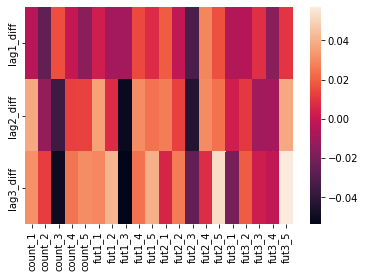

In [ ]:
# Correlation matrix including three economic lags

corrMatrix = econ_bband_cf.loc[econ_bband_cf.year <2017
                              ][['lag1_diff','lag2_diff','lag3_diff','count_1',
              'count_2','count_3','count_4','count_5','fut1_1','fut1_2',
              'fut1_3','fut1_4','fut1_5','fut2_1','fut2_2','fut2_3','fut2_4',
              'fut2_5','fut3_1','fut3_2','fut3_3','fut3_4','fut3_5'
              ]].corr().iloc[:3,3:]
sb.heatmap(corrMatrix, annot=False, fmt='g')
plt.show()

In [ ]:
# Here is the matrix in numbers instead of colors
corrMatrix

,count_1,count_2,count_3,count_4,count_5,fut1_1,fut1_2,fut1_3,fut1_4,fut1_5,fut2_1,fut2_2,fut2_3,fut2_4,fut2_5,fut3_1,fut3_2,fut3_3,fut3_4,fut3_5
lag1_diff,-0.003668,-0.026004,0.016111,0.000339,-0.015464,0.002786,-0.009149,-0.008878,0.014680,0.007293,0.019240,-0.001299,-0.031941,0.029130,0.016596,-0.005059,-0.004764,0.008567,-0.015229,0.010265
lag2_diff,0.038040,-0.012760,-0.035748,0.012687,0.013560,0.036065,0.007353,-0.050667,0.031035,0.024237,0.027043,0.012542,-0.043009,0.030452,0.023821,0.002985,0.010953,-0.009395,-0.008862,0.037586
lag3_diff,0.031726,0.012060,-0.050030,0.024597,0.030668,0.029681,0.041405,-0.053730,0.024451,0.040075,0.005406,0.026691,-0.025198,0.007865,0.053090,-0.019562,0.019130,0.002148,-0.001339,0.057018


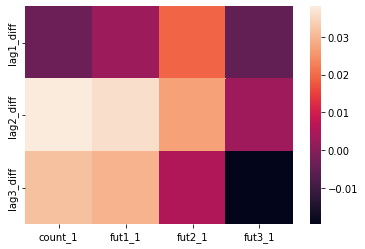

In [ ]:
# Here is the correlation matrix for just economic category 1 over time

sb.heatmap(corrMatrix[['count_1','fut1_1','fut2_1','fut3_1']], annot=False, fmt='g')
plt.show()

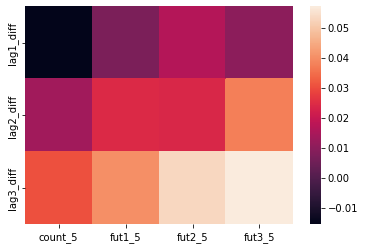

In [ ]:
# Here is the correlation matrix for just group 5 over time
sb.heatmap(corrMatrix[['count_5','fut1_5','fut2_5','fut3_5']], annot=False, fmt='g')
plt.show()

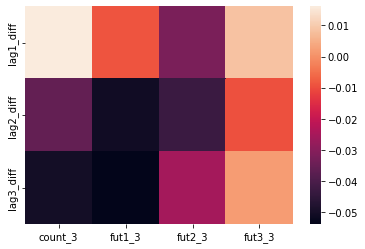

In [ ]:
# Here is the correlation matrix for just group 3 over time
sb.heatmap(corrMatrix[['count_3','fut1_3','fut2_3','fut3_3']], annot=False, fmt='g')
plt.show()

Correlation matrices suggest that positive shocks in broadband are felt most strongly as time passes. The strongest positive correlations is found between an increase in broadband and an increase in the positive, Group 5 economic scores after three elapsed years. Meanwhile, the strongest negative correlation is found when a year or less elapsed with economic Group 3, which is essentially the "average" group. This suggests a possible reverse causation where an area that is neither struggling nor thriving tends to not attract infrastructure investment.

The plot of Group 1, a declining economic group, does not show strong correlation, but its sign moves from positive to negative as years elapse, indicating that areas which receive broadband investment may tend to not decline.

## Part 2: Characteristics of Successful Broadband and Internet Expenditure

### Section 2.A: Combining Data Sources

#### 2.A Broadband Scores

In [ ]:
bband_p.head(2)

,GEOID_x,year,population,tract_fips,state,county,tract,statename,countyname,normalized_score,lag1_diff,lag2_diff,lag3_diff
0,1055010700,2012,3676.0,1055010700,1,55,10700,Alabama,Etowah County,-0.650655,-0.311142,NaN,NaN
1,1055001300,2012,2727.0,1055001300,1,55,1300,Alabama,Etowah County,-1.624723,-0.492884,NaN,NaN


#### 2.A Economic Groupings

In [ ]:
# Create new simplified economic table by concatenating scaled down original versions

e_t=pd.concat([e15_s[['year','GEOID_x','state','county','cluster_sorted']],
               e16_s[['year','GEOID_x','state','county','cluster_sorted']],
               e17_s[['year','GEOID_x','state','county','cluster_sorted']],
               e18_s[['year','GEOID_x','state','county','cluster_sorted']],
               e19_s[['year','GEOID_x','state','county','cluster_sorted']]])
e_t.head(2)

,year,GEOID_x,state,county,cluster_sorted
0,2015,1055010300,1,55,3
1,2015,1055000600,1,55,3


In [ ]:
# Creat the year it would merge into if you are looking to lag the economic effect

e_t['year_off1']=e_t['year']-1
e_t['year_off2']=e_t['year']-2
e_t['year_off3']=e_t['year']-3
e_t.head(2)

,year,GEOID_x,state,county,cluster_sorted,year_off1,year_off2,year_off3
0,2015,1055010300,1,55,3,2014,2013,2012
1,2015,1055000600,1,55,3,2014,2013,2012


#### 2.A ACS data

In [ ]:
# Make sure all acs tables have the same columns
acs12['density']=acs12['population']/acs12['Shape_Area']

In [ ]:
# We want the demographic conditions at year 0, but if we want to connect to a lag 3 broadband data we will need 
# to add three years to it. This way we are looking at year 0 demographics, year 0-3 broadband change, 
# and year 3 to 6 economic change.

acs12['year_base']=acs12['year']+3
acs13['year_base']=acs13['year']+3
acs14['year_base']=acs14['year']+3
acs15['year_base']=acs15['year']+3
acs16['year_base']=acs16['year']+3
acs17['year_base']=acs17['year']+3
acs18['year_base']=acs18['year']+3
acs19['year_base']=acs19['year']+3

##### 2.A.i Demographic Selection

In [ ]:
# Select most relevant demographics from acs data.

demo12=acs12[['GEOID_x','year_base',
              
              'density', 'median_age','under_18','percent_male', 'percent_female',
       
       'white_nonhispanic', 'black_nonhispanic', 'native_nonhispanic',
       'asian_nonhispanic', 'pacific_islander_nonhispanic',
       'other_nonhispanic', 'mixed_nonhispanic', 'hispanic',
       
       'percent_noncitizen', 'born_in_state', 'born_in_other_state',
       'foreign_born', 'spanish_no_english', 'no_english', 
       
       'work_from_home','average_commute',
       
       'highschool_or_less','no_bachelor_degree', 'bachelor_degree_only',
       'advanced_degree',
       
       'percent_poverty', 'more_than_200k','median_household_income',
       
       'percentage_unemployed','percentage_employed', 
       'percentage_outside_labor_force',
       
       'percentage_in_military','management_business_science_art',
       'service_professions', 'sales_office_professions',
       'naturalresources_construction_maintenance',
       'production_transportation_professions',
       
       'vacant','owner_occupied', 'rented',
       
       'home_value_low_quartile', 'home_value_median',
       'home_value_hi_quartile', 'median_rent']]
demo13=acs13[['GEOID_x','year_base',
              
              'density', 'median_age','under_18','percent_male', 'percent_female',
       
       'white_nonhispanic', 'black_nonhispanic', 'native_nonhispanic',
       'asian_nonhispanic', 'pacific_islander_nonhispanic',
       'other_nonhispanic', 'mixed_nonhispanic', 'hispanic',
       
       'percent_noncitizen', 'born_in_state', 'born_in_other_state',
       'foreign_born', 'spanish_no_english', 'no_english', 
       
       'work_from_home','average_commute',
       
       'highschool_or_less','no_bachelor_degree', 'bachelor_degree_only',
       'advanced_degree',
       
       'percent_poverty', 'more_than_200k','median_household_income',
       
       'percentage_unemployed','percentage_employed', 
       'percentage_outside_labor_force',
       
       'percentage_in_military','management_business_science_art',
       'service_professions', 'sales_office_professions',
       'naturalresources_construction_maintenance',
       'production_transportation_professions',
       
       'vacant','owner_occupied', 'rented',
       
       'home_value_low_quartile', 'home_value_median',
       'home_value_hi_quartile', 'median_rent']]
demo14=acs14[['GEOID_x','year_base',
              
              'density', 'median_age','under_18','percent_male', 'percent_female',
       
       'white_nonhispanic', 'black_nonhispanic', 'native_nonhispanic',
       'asian_nonhispanic', 'pacific_islander_nonhispanic',
       'other_nonhispanic', 'mixed_nonhispanic', 'hispanic',
       
       'percent_noncitizen', 'born_in_state', 'born_in_other_state',
       'foreign_born', 'spanish_no_english', 'no_english', 
       
       'work_from_home','average_commute',
       
       'highschool_or_less','no_bachelor_degree', 'bachelor_degree_only',
       'advanced_degree',
       
       'percent_poverty', 'more_than_200k','median_household_income',
       
       'percentage_unemployed','percentage_employed', 
       'percentage_outside_labor_force',
       
       'percentage_in_military','management_business_science_art',
       'service_professions', 'sales_office_professions',
       'naturalresources_construction_maintenance',
       'production_transportation_professions',
       
       'vacant','owner_occupied', 'rented',
       
       'home_value_low_quartile', 'home_value_median',
       'home_value_hi_quartile', 'median_rent']]
demo15=acs15[['GEOID_x','year_base',
              
              'density', 'median_age','under_18','percent_male', 'percent_female',
       
       'white_nonhispanic', 'black_nonhispanic', 'native_nonhispanic',
       'asian_nonhispanic', 'pacific_islander_nonhispanic',
       'other_nonhispanic', 'mixed_nonhispanic', 'hispanic',
       
       'percent_noncitizen', 'born_in_state', 'born_in_other_state',
       'foreign_born', 'spanish_no_english', 'no_english', 
       
       'work_from_home','average_commute',
       
       'highschool_or_less','no_bachelor_degree', 'bachelor_degree_only',
       'advanced_degree',
       
       'percent_poverty', 'more_than_200k','median_household_income',
       
       'percentage_unemployed','percentage_employed', 
       'percentage_outside_labor_force',
       
       'percentage_in_military','management_business_science_art',
       'service_professions', 'sales_office_professions',
       'naturalresources_construction_maintenance',
       'production_transportation_professions',
       
       'vacant','owner_occupied', 'rented',
       
       'home_value_low_quartile', 'home_value_median',
       'home_value_hi_quartile', 'median_rent']]
demo16=acs16[['GEOID_x','year_base',
              
              'density', 'median_age','under_18','percent_male', 'percent_female',
       
       'white_nonhispanic', 'black_nonhispanic', 'native_nonhispanic',
       'asian_nonhispanic', 'pacific_islander_nonhispanic',
       'other_nonhispanic', 'mixed_nonhispanic', 'hispanic',
       
       'percent_noncitizen', 'born_in_state', 'born_in_other_state',
       'foreign_born', 'spanish_no_english', 'no_english', 
       
       'work_from_home','average_commute',
       
       'highschool_or_less','no_bachelor_degree', 'bachelor_degree_only',
       'advanced_degree',
       
       'percent_poverty', 'more_than_200k','median_household_income',
       
       'percentage_unemployed','percentage_employed', 
       'percentage_outside_labor_force',
       
       'percentage_in_military','management_business_science_art',
       'service_professions', 'sales_office_professions',
       'naturalresources_construction_maintenance',
       'production_transportation_professions',
       
       'vacant','owner_occupied', 'rented',
       
       'home_value_low_quartile', 'home_value_median',
       'home_value_hi_quartile', 'median_rent']]
demo17=acs17[['GEOID_x','year_base',
              
              'density', 'median_age','under_18','percent_male', 'percent_female',
       
       'white_nonhispanic', 'black_nonhispanic', 'native_nonhispanic',
       'asian_nonhispanic', 'pacific_islander_nonhispanic',
       'other_nonhispanic', 'mixed_nonhispanic', 'hispanic',
       
       'percent_noncitizen', 'born_in_state', 'born_in_other_state',
       'foreign_born', 'spanish_no_english', 'no_english', 
       
       'work_from_home','average_commute',
       
       'highschool_or_less','no_bachelor_degree', 'bachelor_degree_only',
       'advanced_degree',
       
       'percent_poverty', 'more_than_200k','median_household_income',
       
       'percentage_unemployed','percentage_employed', 
       'percentage_outside_labor_force',
       
       'percentage_in_military','management_business_science_art',
       'service_professions', 'sales_office_professions',
       'naturalresources_construction_maintenance',
       'production_transportation_professions',
       
       'vacant','owner_occupied', 'rented',
       
       'home_value_low_quartile', 'home_value_median',
       'home_value_hi_quartile', 'median_rent']]
demo18=acs18[['GEOID_x','year_base',
              
              'density', 'median_age','under_18','percent_male', 'percent_female',
       
       'white_nonhispanic', 'black_nonhispanic', 'native_nonhispanic',
       'asian_nonhispanic', 'pacific_islander_nonhispanic',
       'other_nonhispanic', 'mixed_nonhispanic', 'hispanic',
       
       'percent_noncitizen', 'born_in_state', 'born_in_other_state',
       'foreign_born', 'spanish_no_english', 'no_english', 
       
       'work_from_home','average_commute',
       
       'highschool_or_less','no_bachelor_degree', 'bachelor_degree_only',
       'advanced_degree',
       
       'percent_poverty', 'more_than_200k','median_household_income',
       
       'percentage_unemployed','percentage_employed', 
       'percentage_outside_labor_force',
       
       'percentage_in_military','management_business_science_art',
       'service_professions', 'sales_office_professions',
       'naturalresources_construction_maintenance',
       'production_transportation_professions',
       
       'vacant','owner_occupied', 'rented',
       
       'home_value_low_quartile', 'home_value_median',
       'home_value_hi_quartile', 'median_rent']]
demo19=acs19[['GEOID_x','year_base',
              
              'density', 'median_age','under_18','percent_male', 'percent_female',
       
       'white_nonhispanic', 'black_nonhispanic', 'native_nonhispanic',
       'asian_nonhispanic', 'pacific_islander_nonhispanic',
       'other_nonhispanic', 'mixed_nonhispanic', 'hispanic',
       
       'percent_noncitizen', 'born_in_state', 'born_in_other_state',
       'foreign_born', 'spanish_no_english', 'no_english', 
       
       'work_from_home','average_commute',
       
       'highschool_or_less','no_bachelor_degree', 'bachelor_degree_only',
       'advanced_degree',
       
       'percent_poverty', 'more_than_200k','median_household_income',
       
       'percentage_unemployed','percentage_employed', 
       'percentage_outside_labor_force',
       
       'percentage_in_military','management_business_science_art',
       'service_professions', 'sales_office_professions',
       'naturalresources_construction_maintenance',
       'production_transportation_professions',
       
       'vacant','owner_occupied', 'rented',
       
       'home_value_low_quartile', 'home_value_median',
       'home_value_hi_quartile', 'median_rent']]

##### 2.A.ii Create Master Demographics Table

In [ ]:
# Concatenate demographic tables into one table

demo=pd.concat([demo12,demo13,demo14,demo15,demo16,demo17,demo18,demo19])

#### 2.A Merge

In [ ]:
# Merge demographics, broadband change, and economic change into one table.

df_14_17=bband_p.loc[bband_p.year>2013].merge(e_t[['year_off3','GEOID_x','cluster_sorted']],
                                           left_on=['year','tract_fips'],
                                           right_on=['year_off3','GEOID_x'])
df_14_17=df_14_17.merge(demo,left_on=['year','tract_fips'],right_on=['year_base','GEOID_x'])

### Section 2.B: Analyses

In [ ]:
# Create subsets of the data. Including increasing broadband and group 5 economic score, 
# relatively decreasing broadband score but also group 5,
# increasing broadband score but not group 5,
# and decreasing broadband score and not group 5

inc_5=df_14_17.loc[(df_14_17.normalized_score>0)&(df_14_17.cluster_sorted==5)]
dec_5=df_14_17.loc[(df_14_17.normalized_score<0)&(df_14_17.cluster_sorted==5)]
inc_other=df_14_17.loc[(df_14_17.normalized_score>0)&(df_14_17.cluster_sorted!=5)]
dec_other=df_14_17.loc[(df_14_17.normalized_score<0)&(df_14_17.cluster_sorted!=5)]

In [ ]:
# Label each type of group outlined above in the combined table
analyses_group=[]
for i in range(len(df_14_17)):
  if (df_14_17.iloc[i].normalized_score>0)&(df_14_17.iloc[i].cluster_sorted==5):
    analyses_group.append('inc_5')
  elif (df_14_17.iloc[i].normalized_score<0)&(df_14_17.iloc[i].cluster_sorted==5):
    analyses_group.append('dec_5')
  elif (df_14_17.iloc[i].normalized_score>0)&(df_14_17.iloc[i].cluster_sorted!=5):
    analyses_group.append('inc_other')
  elif (df_14_17.iloc[i].normalized_score<0)&(df_14_17.iloc[i].cluster_sorted!=5):
    analyses_group.append('dec_other')

df_14_17['a_group']=analyses_group

In [ ]:
# Finding lengths of each subcategory

print(f'There are {len(inc_5)} tracts that increased their relative broadband\
 between 2011 and 2014 and had an economic development score of 5 between 2014-2017')

print(f'There are {len(dec_5)} tracts that decreased their relative broadband\
 between 2011 and 2014 and had an economic development score of 5 between 2014-2017')

print(f'There are {len(inc_other)} tracts that increased their relative broadband\
 between 2011 and 2014 and did not have an economic development score of 5 between 2014-2017')

print(f'There are {len(dec_other)} tracts that decreased their relative broadband\
 between 2011 and 2014 and did not have an economic development score of 5 between 2014-2017')

There are 10897 tracts that increased their relative broadband between 2011 and 2014 and had an economic development score of 5 between 2014-2017
There are 3326 tracts that decreased their relative broadband between 2011 and 2014 and had an economic development score of 5 between 2014-2017
There are 71254 tracts that increased their relative broadband between 2011 and 2014 and did not have an economic development score of 5 between 2014-2017
There are 61757 tracts that decreased their relative broadband between 2011 and 2014 and did not have an economic development score of 5 between 2014-2017


In [ ]:
# Find general statistics for those areas with a positive score
mean_df=pd.DataFrame(data=df_14_17.iloc[:,18:62].mean()).rename(columns={0:'mean'})

std_df=pd.DataFrame(data=df_14_17.iloc[:,18:62].std()).rename(columns={0:'std'})
stat_df=mean_df.merge(std_df, left_index=True,right_index=True)

In [ ]:
#Prepare statistics by cluster
clust=df_14_17.iloc[:,18:].groupby(by='a_group').mean()
clust=clust.swapaxes('index','columns')
clust=clust.merge(stat_df, left_index=True,right_index=True)

#Normalize for graphing purposes
clust['norm_d5']=(clust['dec_5']-clust['mean'])/clust['std']+1
clust['norm_dn']=(clust['dec_other']-clust['mean'])/clust['std']+1
clust['norm_i5']=(clust['inc_5']-clust['mean'])/clust['std']+1
clust['norm_in']=(clust['inc_other']-clust['mean'])/clust['std']+1

### Section 2.C: Clusters of Related Variables

#### 2.C.i General Statistics

In [ ]:
clust.iloc[:5]

,dec_5,dec_other,inc_5,inc_other,mean,std,norm_d5,norm_dn,norm_i5,norm_in
density,4.430369e+07,1.138934e+07,4.279528e+07,2.094300e+07,1.908077e+07,4.144363e+07,1.608608,0.814412,1.572211,1.044934
median_age,3.363378e+01,3.822869e+01,3.731320e+01,3.893655e+01,3.839971e+01,7.487540e+00,0.363486,0.977160,0.854892,1.071699
under_18,2.561413e-01,2.402526e-01,2.083793e-01,2.256706e-01,2.311956e-01,6.930178e-02,1.359958,1.130690,0.670770,0.920277
percent_male,5.008460e-01,4.944371e-01,4.941847e-01,4.885767e-01,4.917270e-01,4.883514e-02,1.186729,1.055494,1.050326,0.935490
percent_female,4.991540e-01,5.055629e-01,5.058153e-01,5.114233e-01,5.082730e-01,4.883514e-02,0.813271,0.944506,0.949674,1.064510


In [ ]:
# Radial Plot illustration of table above

fig = go.Figure()

fig.add_trace(go.Scatterpolar(r=clust.norm_d5,theta=clust.iloc[:5].index,fill='toself',name='Economic Group 5, Declining Relative Broadband Score'))
#fig.add_trace(go.Scatterpolar(r=clust.norm_dn,theta=clust.iloc[:5].index,fill='toself',name='Cluster 1'))
fig.add_trace(go.Scatterpolar(r=clust.norm_i5,theta=clust.iloc[:5].index,fill='toself',name='Economic Group 5, Increasing Relative Broadband Score'))
fig.add_trace(go.Scatterpolar(r=clust.norm_in,theta=clust.iloc[:5].index,fill='toself',name='Economic Group is not 5, Increasing Relative Broadband Score'))

fig.update_layout(polar=dict(radialaxis=dict(visible=True,range=[0, 2.5])),showlegend=True)

fig.show()

#### 2.C.ii Ethnicity statistics

In [ ]:
ethn=clust.iloc[5:12]
ethn

,dec_5,dec_other,inc_5,inc_other,mean,std,norm_d5,norm_dn,norm_i5,norm_in
white_nonhispanic,0.309892,0.610315,0.537138,0.674573,0.629211,0.308202,-0.036070,0.938692,0.701259,1.147185
black_nonhispanic,0.200802,0.168592,0.095612,0.103500,0.132417,0.219956,1.310904,1.164466,0.832671,0.868532
native_nonhispanic,0.005311,0.012164,0.002949,0.003696,0.007229,0.044205,0.956593,1.111641,0.903175,0.920073
asian_nonhispanic,0.052717,0.014873,0.118070,0.057109,0.043806,0.085896,1.103745,0.663167,1.864587,1.154873
pacific_islander_nonhispanic,0.002805,0.000895,0.003004,0.001614,0.001442,0.010628,1.128188,0.948492,1.146930,1.016189
other_nonhispanic,0.002138,0.001177,0.003063,0.002406,0.001933,0.007884,1.025992,0.904119,1.143358,1.059965
mixed_nonhispanic,0.016967,0.017279,0.027168,0.020985,0.019797,0.024519,0.884548,0.897291,1.300592,1.048439


In [ ]:
fig = go.Figure()

fig.add_trace(go.Scatterpolar(r=ethn.norm_d5,theta=ethn.index,fill='toself',name='Economic Group 5, Declining Relative Broadband Score'))
#fig.add_trace(go.Scatterpolar(r=clust.norm_dn,theta=clust.iloc[:5].index,fill='toself',name='Cluster 1'))
fig.add_trace(go.Scatterpolar(r=ethn.norm_i5,theta=ethn.index,fill='toself',name='Economic Group 5, Increasing Relative Broadband Score'))
fig.add_trace(go.Scatterpolar(r=ethn.norm_in,theta=ethn.index,fill='toself',name='Economic Group is not 5, Increasing Relative Broadband Score'))

fig.update_layout(polar=dict(radialaxis=dict(visible=True,range=[0, 2.5])),showlegend=True)

fig.show()

#### 2.C.iii Place of Origin

In [ ]:
orig=clust.iloc[13:19]
orig

,dec_5,dec_other,inc_5,inc_other,mean,std,norm_d5,norm_dn,norm_i5,norm_in
percent_noncitizen,0.177002,0.053536,0.113689,0.066700,0.067307,0.086858,2.262918,0.841449,1.533997,0.993002
born_in_state,0.518518,0.649155,0.474702,0.554110,0.587295,0.196007,0.649107,1.315601,0.425561,0.830692
born_in_other_state,0.208035,0.236430,0.282075,0.293983,0.267020,0.163021,0.638178,0.812358,1.092349,1.165399
foreign_born,0.257964,0.078978,0.225671,0.134994,0.120987,0.136019,2.007040,0.691151,1.769629,1.102977
spanish_no_english,0.183744,0.055842,0.071548,0.041938,0.053136,0.096460,2.353999,1.028052,1.190870,0.883912
no_english,0.041758,0.014314,0.062519,0.035607,0.028975,0.053533,1.238781,0.726129,1.626600,1.123889


In [ ]:
fig = go.Figure()

fig.add_trace(go.Scatterpolar(r=orig.norm_d5,theta=orig.index,fill='toself',name='Economic Group 5, Declining Relative Broadband Score'))
#fig.add_trace(go.Scatterpolar(r=clust.norm_dn,theta=clust.iloc[:5].index,fill='toself',name='Cluster 1'))
fig.add_trace(go.Scatterpolar(r=orig.norm_i5,theta=orig.index,fill='toself',name='Economic Group 5, Increasing Relative Broadband Score'))
fig.add_trace(go.Scatterpolar(r=orig.norm_in,theta=orig.index,fill='toself',name='Economic Group is not 5, Increasing Relative Broadband Score'))

fig.update_layout(polar=dict(radialaxis=dict(visible=True,range=[0, 2.5])),showlegend=True)

fig.show()

#### 2.C.iv Education Level

In [ ]:
ed=clust.iloc[21:25]
ed

,dec_5,dec_other,inc_5,inc_other,mean,std,norm_d5,norm_dn,norm_i5,norm_in
highschool_or_less,0.272180,0.343663,0.193459,0.251553,0.286354,0.109725,0.870819,1.522290,0.153378,0.682828
no_bachelor_degree,0.524313,0.631999,0.459048,0.544154,0.574254,0.139381,0.641697,1.414298,0.173448,0.784052
bachelor_degree_only,0.116043,0.111461,0.250654,0.215555,0.172242,0.103007,0.454410,0.409928,1.761220,1.420477
advanced_degree,0.057401,0.056772,0.166026,0.135675,0.103057,0.094325,0.515972,0.509300,1.667571,1.345798


In [ ]:
fig = go.Figure()

fig.add_trace(go.Scatterpolar(r=ed.norm_d5,theta=ed.index,fill='toself',name='Economic Group 5, Declining Relative Broadband Score'))
#fig.add_trace(go.Scatterpolar(r=clust.norm_dn,theta=clust.iloc[:5].index,fill='toself',name='Cluster 1'))
fig.add_trace(go.Scatterpolar(r=ed.norm_i5,theta=ed.index,fill='toself',name='Economic Group 5, Increasing Relative Broadband Score'))
fig.add_trace(go.Scatterpolar(r=ed.norm_in,theta=ed.index,fill='toself',name='Economic Group is not 5, Increasing Relative Broadband Score'))

fig.update_layout(polar=dict(radialaxis=dict(visible=True,range=[0, 2.5])),showlegend=True)

fig.show()

#### 2.C.v Income and work style

In [ ]:
work=clust.loc[clust.index.isin(['work_from_home','average_commute','percent_poverty','more_than_200k', 'median_household_income'])]
work

,dec_5,dec_other,inc_5,inc_other,mean,std,norm_d5,norm_dn,norm_i5,norm_in
work_from_home,0.040979,0.037562,0.057235,0.044914,0.042653,0.040094,0.958231,0.873029,1.363699,1.056376
average_commute,26.556727,23.953704,27.276030,25.717269,25.111874,7.146206,1.202185,0.837932,1.302840,1.084715
percent_poverty,0.292112,0.222144,0.135552,0.115411,0.165662,0.132072,1.957435,1.427659,0.772020,0.619515
more_than_200k,0.019591,0.015614,0.089326,0.063782,0.044471,0.071272,0.650923,0.595122,1.629357,1.270960
median_household_income,39739.403788,41033.275677,72233.628567,67679.212192,56208.550328,28059.495690,0.413063,0.459175,1.571111,1.408798


In [ ]:
fig = go.Figure()

fig.add_trace(go.Scatterpolar(r=work.norm_d5,theta=work.index,fill='toself',name='Economic Group 5, Declining Relative Broadband Score'))
#fig.add_trace(go.Scatterpolar(r=clust.norm_dn,theta=clust.iloc[:5].index,fill='toself',name='Cluster 1'))
fig.add_trace(go.Scatterpolar(r=work.norm_i5,theta=work.index,fill='toself',name='Economic Group 5, Increasing Relative Broadband Score'))
fig.add_trace(go.Scatterpolar(r=work.norm_in,theta=work.index,fill='toself',name='Economic Group is not 5, Increasing Relative Broadband Score'))

fig.update_layout(polar=dict(radialaxis=dict(visible=True,range=[0, 2.5])),showlegend=True)

fig.show()

#### 2.C.vi Employment statististics

In [ ]:
lf=clust.iloc[28:31]
lf

,dec_5,dec_other,inc_5,inc_other,mean,std,norm_d5,norm_dn,norm_i5,norm_in
percentage_unemployed,0.085893,0.069137,0.061987,0.056158,0.062705,0.035849,1.646812,1.179417,0.979973,0.817367
percentage_employed,0.521745,0.523354,0.611396,0.605220,0.569453,0.113403,0.579305,0.593496,1.369859,1.315398
percentage_outside_labor_force,0.386978,0.404073,0.322570,0.332592,0.363061,0.106284,1.225028,1.385870,0.619029,0.713319


In [ ]:
fig = go.Figure()

fig.add_trace(go.Scatterpolar(r=lf.norm_d5,theta=lf.index,fill='toself',name='Economic Group 5, Declining Relative Broadband Score'))
#fig.add_trace(go.Scatterpolar(r=clust.norm_dn,theta=clust.iloc[:5].index,fill='toself',name='Cluster 1'))
fig.add_trace(go.Scatterpolar(r=lf.norm_i5,theta=lf.index,fill='toself',name='Economic Group 5, Increasing Relative Broadband Score'))
fig.add_trace(go.Scatterpolar(r=lf.norm_in,theta=lf.index,fill='toself',name='Economic Group is not 5, Increasing Relative Broadband Score'))

fig.update_layout(polar=dict(radialaxis=dict(visible=True,range=[0, 2.5])),showlegend=True)

fig.show()

#### 2.C.vii Professions

In [ ]:
prof=clust.iloc[31:37]
prof

,dec_5,dec_other,inc_5,inc_other,mean,std,norm_d5,norm_dn,norm_i5,norm_in
percentage_in_military,0.005144,0.003363,0.004045,0.006029,0.004744,0.039587,1.010098,0.965119,0.982341,1.032461
management_business_science_art,1.634026,1.522895,1.476150,1.468549,1.495645,0.392878,1.352224,1.069359,0.950380,0.931033
service_professions,0.710179,0.625431,0.540638,0.537839,0.578679,0.223051,1.589550,1.209601,0.829449,0.816899
sales_office_professions,0.967008,0.885899,0.834327,0.823141,0.853543,0.215868,1.525626,1.149889,0.910986,0.859167
naturalresources_construction_maintenance,1.096489,1.179244,0.994305,1.077193,1.114299,0.463507,0.961575,1.140116,0.741116,0.919945
production_transportation_professions,1.012862,1.067930,0.838461,0.903271,0.970016,0.388307,1.110340,1.252156,0.661209,0.828114


In [ ]:
fig = go.Figure()

fig.add_trace(go.Scatterpolar(r=prof.norm_d5,theta=prof.index,fill='toself',name='Economic Group 5, Declining Relative Broadband Score'))
#fig.add_trace(go.Scatterpolar(r=clust.norm_dn,theta=clust.iloc[:5].index,fill='toself',name='Cluster 1'))
fig.add_trace(go.Scatterpolar(r=prof.norm_i5,theta=prof.index,fill='toself',name='Economic Group 5, Increasing Relative Broadband Score'))
fig.add_trace(go.Scatterpolar(r=prof.norm_in,theta=prof.index,fill='toself',name='Economic Group is not 5, Increasing Relative Broadband Score'))

fig.update_layout(polar=dict(radialaxis=dict(visible=True,range=[0, 2.5])),showlegend=True)

fig.show()

#### 2.C.viii Housing Data

In [ ]:
house=clust.iloc[37:]
house

,dec_5,dec_other,inc_5,inc_other,mean,std,norm_d5,norm_dn,norm_i5,norm_in
vacant,0.122477,0.152969,0.089977,0.098569,0.121291,0.105940,1.011194,1.299021,0.704421,0.785515
owner_occupied,0.370902,0.542147,0.507694,0.610703,0.568906,0.218299,0.092964,0.877418,0.719594,1.191466
rented,0.505735,0.304608,0.402317,0.290722,0.309663,0.199967,1.980522,0.974721,1.463346,0.905280
home_value_low_quartile,172885.725797,89314.597973,327918.548775,198392.568263,161650.244074,137382.830904,1.081782,0.473474,2.210255,1.267445
home_value_median,240955.385749,132113.578493,433824.184179,266338.482710,221860.577462,173172.982088,1.110264,0.481749,2.223999,1.256841
home_value_hi_quartile,326367.623271,191564.186036,546522.668074,350945.421548,298013.031861,210517.928111,1.134690,0.494348,2.180468,1.251439
median_rent,935.505713,722.374848,1319.195467,1106.714942,957.362668,377.725173,0.942135,0.377887,1.957926,1.395399


In [ ]:
fig = go.Figure()

fig.add_trace(go.Scatterpolar(r=house.norm_d5,theta=house.index,fill='toself',name='Economic Group 5, Declining Relative Broadband Score'))
#fig.add_trace(go.Scatterpolar(r=clust.norm_dn,theta=clust.iloc[:5].index,fill='toself',name='Cluster 1'))
fig.add_trace(go.Scatterpolar(r=house.norm_i5,theta=house.index,fill='toself',name='Economic Group 5, Increasing Relative Broadband Score'))
fig.add_trace(go.Scatterpolar(r=house.norm_in,theta=house.index,fill='toself',name='Economic Group is not 5, Increasing Relative Broadband Score'))

fig.update_layout(polar=dict(radialaxis=dict(visible=True,range=[0, 2.5])),showlegend=True)

fig.show()

### Section 2.D: Total Results Between Categories of Tracts and Assorted Variables

In [ ]:
clust['order']=np.abs(clust.norm_i5-1)
clust['diff_from_5']=clust.norm_i5-clust.norm_d5
clust['diff_from_increasing_b']=clust.norm_i5-clust.norm_in
clust.sort_values(by=['order'],ascending=False)[['norm_i5','diff_from_5','diff_from_increasing_b']]

,norm_i5,diff_from_5,diff_from_increasing_b
home_value_median,2.223999,1.113735,0.967158
home_value_low_quartile,2.210255,1.128473,0.942811
home_value_hi_quartile,2.180468,1.045778,0.929029
median_rent,1.957926,1.015791,0.562527
asian_nonhispanic,1.864587,0.760843,0.709714
highschool_or_less,0.153378,-0.717440,-0.529450
no_bachelor_degree,0.173448,-0.468249,-0.610604
foreign_born,1.769629,-0.237411,0.666652
bachelor_degree_only,1.761220,1.306810,0.340743
advanced_degree,1.667571,1.151598,0.321773


## Part 3: Equity Score Pairing

### Section 3.A: Preparing Broadband Indicators

We can get a more precise snapshot by generating a pca score, although it will not have the same weighted longitudinal properties that made our previous broadband score helpful. To find inequality of internet distribution as it existed in 2019 we will generate this pca score

In [ ]:
# Find percentage of households with internet and broadband (from American Communities Survey)
bband19['internet_percent']=bband19.has_internet/bband19.households*100
bband19['broadband_percent']=bband19.has_broadband/bband19.households*100

In [ ]:
# Create a Geoid that can pair with the geoids we have been using by slice out leading letters and numbers
geokeys=[]
for i in range(len(bband19)):
  geokeys.append(int(bband19.iloc[i].GEOID[7:]))

bband19['key']=geokeys

In [ ]:
# Merge with indicators of broadband need
broadband19=bband19[['key',
         'internet_percent',
         'broadband_percent']].merge(ibn,left_on='key',
                                     right_on='Geographic Identifier - FIPS Code')

In [ ]:
# Narrow to relevant indicators
ind19=broadband19[['key','internet_percent','broadband_percent',
             'Form 477 All Terrestrial Broadband: Max Advertised Consumer Download Speed (Mbps)',
             'Form 477 All Terrestrial Broadband: Max Advertised Consumer Upload Speed (Mbps)',
             'Ookla Median Download Speed (Mbps)','Ookla Median Upload Speed (Mbps)']]

In [ ]:
# Rename columns for simplicity
ind19=ind19.rename(columns={'Form 477 All Terrestrial Broadband: Max Advertised Consumer Download Speed (Mbps)':'fcc_down',
                      'Form 477 All Terrestrial Broadband: Max Advertised Consumer Upload Speed (Mbps)':'fcc_up',
                      'Ookla Median Download Speed (Mbps)':'ookla_down',
                      'Ookla Median Upload Speed (Mbps)':'ookla_up'}).set_index('key')

### Section 3.B: Find PCA Transform

In [ ]:
#Standardize indicators
ind19_norm=ind19.copy()
ind19_norm['internet_percent']=(ind19.internet_percent-ind19.internet_percent.mean())/ind19.internet_percent.std()
ind19_norm['broadband_percent']=(ind19.broadband_percent-ind19.broadband_percent.mean())/ind19.broadband_percent.std()
ind19_norm['fcc_down']=(ind19.fcc_down-ind19.fcc_down.mean())/ind19.fcc_down.std()
ind19_norm['fcc_up']=(ind19.fcc_up-ind19.fcc_up.mean())/ind19.fcc_up.std()
ind19_norm['ookla_down']=(ind19.ookla_down-ind19.ookla_down.mean())/ind19.ookla_down.std()
ind19_norm['ookla_up']=(ind19.ookla_up-ind19.ookla_up.mean())/ind19.ookla_up.std()
ind19_norm=ind19_norm.dropna()

In [ ]:
#Preprocess data
scaler_data = preprocessing.StandardScaler().fit(ind19_norm)
dataS=scaler_data.transform(ind19_norm) 

In [ ]:
# Find PCA score and explained variance
pca=PCA(1)
dataP=pca.fit_transform(dataS)
eigenvalues = pca.explained_variance_ratio_
eigenvalues

In [ ]:
# Add to our dataframe of indicators by adding to standardized dataframe
ind19_norm['pca_score']=dataP
ind19_norm.head()

### Section 3.C: Connecting Scores to Geography

In [ ]:
# Add the pca_score we found to the acs 19 table
df19=acs19.merge(ind19_norm[['pca_score']],right_index=True,left_on='GEOID_x')

In [ ]:
# Convert the geometry column from a string to a geometry field
df19['geometry'] = df19['geometry'].apply(wkt.loads)

In [ ]:
# Convert the dataframe into a geodataframe
gdf19=gpd.GeoDataFrame(df19, geometry='geometry')

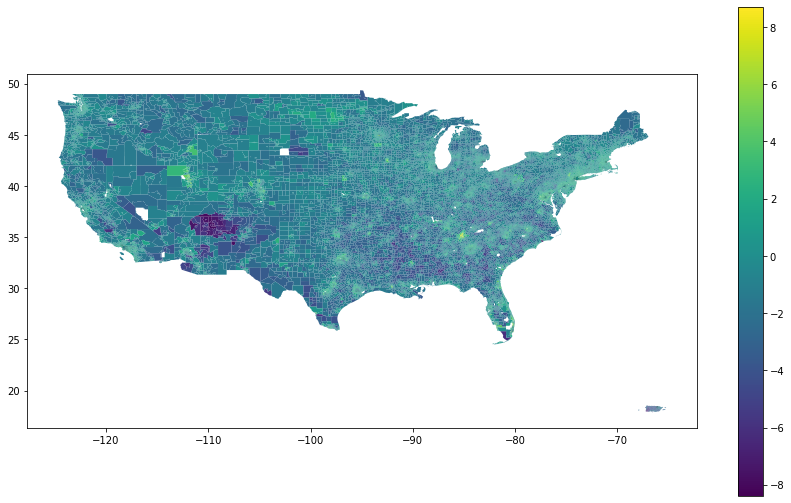

In [ ]:
gdf19.loc[(gdf19.INTPTLON<-50)&(gdf19.INTPTLON>-130)].plot(figsize = (15,9),
                                                           column='pca_score',
                                                           legend=True)

### Section 3.D: Grouping by Density

In [ ]:
# Log of density scales better than density itself, because there are only a few hyperdense tracts
df19['dense_log']=np.log(df19.density)

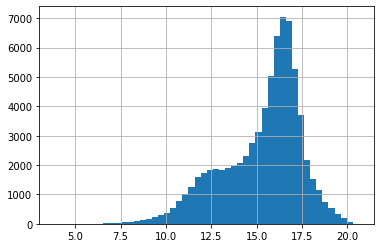

In [ ]:
#Observe the pattern density in a histogram
df19['dense_log'].hist(bins=50)

This density histogram shows dual peaks. I estimate the dividing line at around log(density)=14. I assume one curve is for metropolitan regions, while the other curve is for rural communities. I will further divide these regions in half to create four categories: urban, suburban, town, and rural.

In [ ]:
urban_mid=df19.loc[df19.dense_log>=14].dense_log.median()
rural_mid=df19.loc[df19.dense_log<14].dense_log.median()

In [ ]:
urban=df19.loc[df19.dense_log>=urban_mid]
suburban=df19.loc[(df19.dense_log>=14)&(df19.dense_log<urban_mid)]
town=df19.loc[(df19.dense_log>=rural_mid)&(df19.dense_log<14)]
rural=df19.loc[df19.dense_log<rural_mid]

In [ ]:
#Exploratory analyses of the groups I generated
print(f'The average urban pca internet score is {round(urban.pca_score.mean(),4)} \
and the number of census tracts is {len(urban)}')

print(f'The average suburban pca internet score is {round(suburban.pca_score.mean(),4)} \
and the number of census tracts is {len(suburban)}')

print(f'The average town pca internet score is {round(town.pca_score.mean(),4)} \
and the number of census tracts is {len(town)}')

print(f'The average rural pca internet score is {round(rural.pca_score.mean(),4)} \
and the number of census tracts is {len(rural)}')

The average urban pca internet score is 0.342 and the number of census tracts is 27439
The average suburban pca internet score is 0.301 and the number of census tracts is 27439
The average town pca internet score is -0.4442 and the number of census tracts is 9094
The average rural pca internet score is -1.496 and the number of census tracts is 9093


In [ ]:
# Add these categories as a column to the geodataframe
tract_type=[]
for i in range(len(gdf19)):
  if np.log(gdf19.iloc[i].density)>=urban_mid:
    tract_type.append('urban')
  elif (np.log(gdf19.iloc[i].density)>=14)&(np.log(gdf19.iloc[i].density)<urban_mid):
    tract_type.append('suburban')
  elif (np.log(gdf19.iloc[i].density)>=rural_mid)&(np.log(gdf19.iloc[i].density)<14):
    tract_type.append('town')
  elif np.log(gdf19.iloc[i].density)<rural_mid:
    tract_type.append('rural')
    
gdf19['tract_type']=tract_type

In [ ]:
gdf19['tract_type']=tract_type

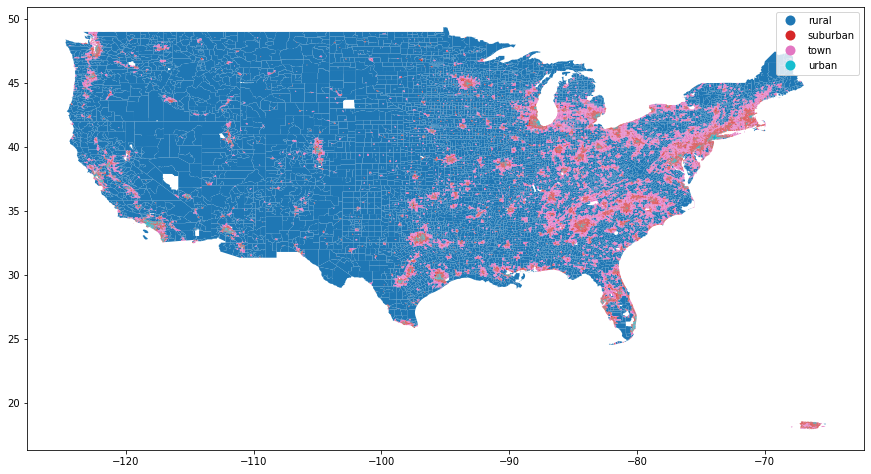

In [ ]:
gdf19.loc[(gdf19.INTPTLON<-50)&(gdf19.INTPTLON>-130)].plot(figsize = (15,9),
                                                           column='tract_type',
                                                           legend=True)

Looks like my classification is mostly correct, although a lot of the areas I classified as "towns" are exurbs and some less-dense cities might be classified entirely as suburbs. Still, the general classification seems to work

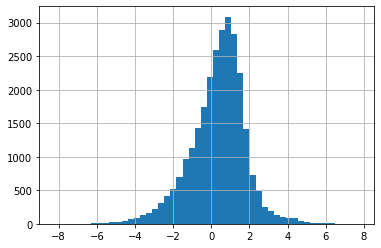

In [ ]:
# Sanity check using a histogram
urban['pca_score'].hist(bins=50)

(-10.0, 10.0)

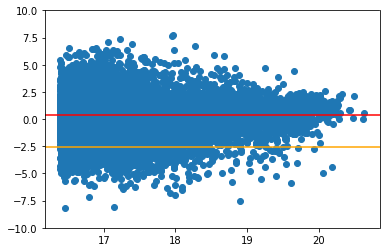

In [ ]:
# PCA increase over increasing log density is essentially flat.
# Creat an orange line demarcating outliers for urban areas
df_mean=urban.pca_score.mean()
ustd2=-2*urban.pca_score.std()+df_mean
plt.scatter(x=urban.dense_log,y=urban.pca_score)
plt.axhline(y=df_mean, color='r', linestyle='-')
plt.axhline(y=ustd2, color='orange', linestyle='-')
plt.ylim([-10,10])

(-10.0, 10.0)

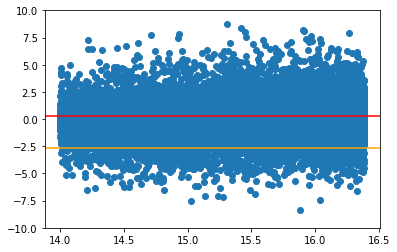

In [ ]:
# Creat an orange line demarcating outliers for suburban areas
df_mean=suburban.pca_score.mean()
sstd2=-2*suburban.pca_score.std()+df_mean
plt.scatter(x=suburban.dense_log,y=suburban.pca_score)
plt.axhline(y=df_mean, color='r', linestyle='-')
plt.axhline(y=sstd2, color='orange', linestyle='-')
plt.ylim([-10,10])

(-10.0, 10.0)

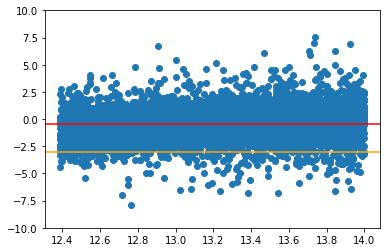

In [ ]:
df_mean=town.pca_score.mean()
tstd2=-2*town.pca_score.std()+df_mean
plt.scatter(x=town.dense_log,y=town.pca_score)
plt.axhline(y=df_mean, color='r', linestyle='-')
plt.axhline(y=tstd2, color='orange', linestyle='-')
plt.ylim([-10,10])

(-10.0, 10.0)

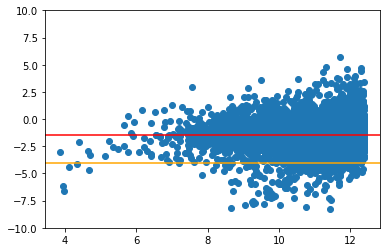

In [ ]:
df_mean=rural.pca_score.mean()
rstd2=-2*rural.pca_score.std()+df_mean
plt.scatter(x=rural.dense_log,y=rural.pca_score)
plt.axhline(y=df_mean, color='r', linestyle='-')
plt.axhline(y=rstd2, color='orange', linestyle='-')
plt.ylim([-10,10])

Calculate "outlierness" by grouping tracts into internet standard deviation groups

In [ ]:
urban_mean,urban_std=urban.pca_score.mean(),urban.pca_score.std()
suburban_mean,suburban_std=suburban.pca_score.mean(),suburban.pca_score.std()
town_mean,town_std=town.pca_score.mean(),town.pca_score.std()
rural_mean,rural_std=rural.pca_score.mean(),rural.pca_score.std()

In [ ]:
# Append standard deviation group as a column to larger geodataframe
std_group=[]
for i in range(len(gdf19)):
  if gdf19.iloc[i].tract_type=='urban':
    out_grp=round((gdf19.iloc[i].pca_score-urban_mean)/urban_std,0)
    std_group.append(out_grp)
  elif gdf19.iloc[i].tract_type=='suburban':
    out_grp=round((gdf19.iloc[i].pca_score-suburban_mean)/suburban_std,0)
    std_group.append(out_grp)
  elif gdf19.iloc[i].tract_type=='town':
    out_grp=round((gdf19.iloc[i].pca_score-town_mean)/town_std,0)
    std_group.append(out_grp)
  elif gdf19.iloc[i].tract_type=='rural':
    out_grp=round((gdf19.iloc[i].pca_score-rural_mean)/rural_std,0)
    std_group.append(out_grp)

gdf19['std_group']=std_group

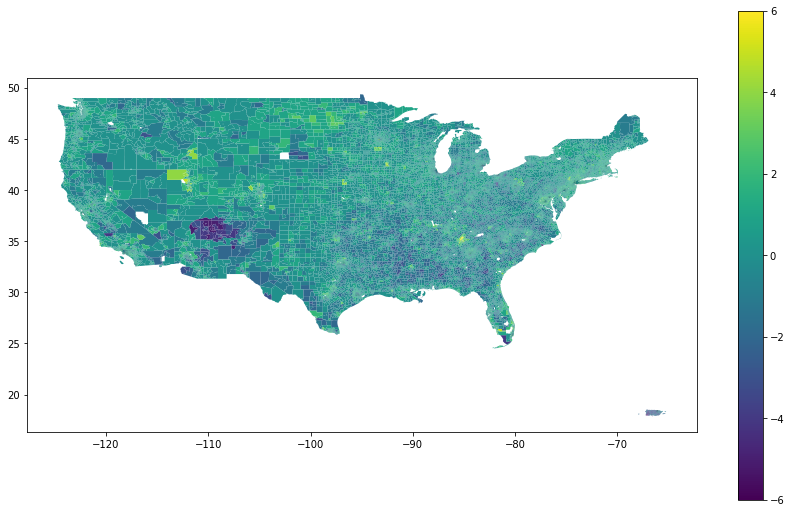

In [ ]:
# Plot the standard deviation outlier groupings

gdf19.loc[(gdf19.INTPTLON<-50)&(gdf19.INTPTLON>-130)].plot(figsize = (15,9),
                                                           column='std_group',
                                                           legend=True)

### Section 3.E: Finding Outliers by Race

In [ ]:
# Group by standard deviation group to see the makeup of those tracts
race_comp=gdf19.groupby(by=['std_group'],as_index=False).apply(lambda x: pd.Series(dict(
    white=(x.white_nonhispanic*x.population).sum(),
    black=(x.black_nonhispanic*x.population).sum(),
    hispanic=(x.hispanic*x.population).sum(),
    asian=(x.asian_nonhispanic*x.population).sum(),
    mixed=(x.mixed_nonhispanic*x.population).sum(),
    native=(x.native_nonhispanic*x.population).sum(),
    p_i=(x.pacific_islander_nonhispanic*x.population).sum(),
    other=(x.other_nonhispanic*x.population).sum(),
    urban=(x.tract_type == 'urban').sum(),
    suburban=(x.tract_type == 'suburban').sum(),
    town=(x.tract_type == 'town').sum(),
    rural=(x.tract_type=='rural').sum(),
    population=x.population.sum())))

race_comp.head(2)

In [ ]:
# Separate into different score-based categories

low_outlier=race_comp.loc[race_comp.std_group<1][['white','black','hispanic','asian','mixed','native','p_i','other','population']]
hi_outlier=race_comp.loc[race_comp.std_group>1][['white','black','hispanic','asian','mixed','native','p_i','other','population']]

In [ ]:
#Create a radial chart of the characteristics of low outliers, high outliers, and the general average.
# We start by restructuring the data sets to fit, and then averageing around the general dataframe

l_o=pd.DataFrame(data=low_outlier.sum()/low_outlier.population.sum()).rename(columns={0:'l_o'}).iloc[:8]
h_o=pd.DataFrame(data=hi_outlier.sum()/hi_outlier.population.sum()).rename(columns={0:'h_o'}).iloc[:8]
not_o=pd.DataFrame(data=race_comp.sum()/race_comp.population.sum()).rename(columns={0:'not_o'}).iloc[1:9]

rc=l_o.merge(h_o,left_index=True,right_index=True).merge(not_o,left_index=True,right_index=True)
rc['l_o']=rc.l_o/rc.not_o
rc['h_o']=rc.h_o/rc.not_o
rc['not_o']=rc.not_o/rc.not_o

rc

In [ ]:
# Plot radial charts

fig = go.Figure()

fig.add_trace(go.Scatterpolar(r=rc.l_o,theta=rc.l_o.index,fill='toself',name='low_outliers'))
fig.add_trace(go.Scatterpolar(r=rc.h_o,theta=rc.h_o.index,fill='toself',name='hi_outliers'))
fig.add_trace(go.Scatterpolar(r=rc.not_o,theta=rc.not_o.index,fill='toself',name='all'))

fig.update_layout(polar=dict(radialaxis=dict(visible=True,range=[0, 1.5])),showlegend=True)

fig.show()

Above is a chart that compares the average racial makeup of low internet outliers (blue), high internet outliers (red), to the overall racial makeup of the country (green).

Black, Hispanic, and Native people are overrepresented in areas with unusually poor internet access and underepresented in areas with unusually high internet access.

### Section 3.F: Finding additional important variables using regression

#### 3.F.i Linear Regression

In [ ]:
# Exam variables for regression, will have to choose relevant ones
df_reg=gdf19[['population', 'density', 'median_age', 'median_age_male',
       'median_age_female', 'percent_male', 'percent_female', 'white', 'black',
       'native', 'asian', 'pacific_islander', 'other', 'mixed',
       'white_nonhispanic', 'black_nonhispanic', 'native_nonhispanic',
       'asian_nonhispanic', 'pacific_islander_nonhispanic',
       'other_nonhispanic', 'mixed_nonhispanic', 'hispanic',
       'percent_noncitizen', 'born_in_state', 'born_in_other_state',
       'foreign_born', 'spanish_no_english', 'no_english', 'work_from_home',
       'average_commute', 'under_18', 'over_18', 'highschool_or_less',
       'no_bachelor_degree', 'bachelor_degree_only', 'advanced_degree',
       'percent_poverty', 'percent_disabled', 'less_than_10k', '10k_15k',
       '15k_20k', '20k_25k', '25k_30k', '30k_35k', '35k_40k', '40k_45k',
       '45k_50k', '50k_60k', '60k_75k', '75k_100k', '100k_125k', '125k_150k',
       '150k_200k', 'more_than_200k', 'percentage_food_stamps',
       'percentage_employed', 'percentage_unemployed',
       'civilian_labor_force_percentage', 'percentage_in_military',
       'percentage_outside_labor_force', 'management_business_science_art',
       'service_professions', 'sales_office_professions',
       'naturalresources_construction_maintenance',
       'production_transportation_professions', 'occupied', 'vacant',
       'owner_occupied', 'rented', 'median_household_income',
       'home_value_low_quartile', 'home_value_median',
       'home_value_hi_quartile', 'median_rent', 'STATEFP', 'COUNTYFP',
       'TRACTCE', 'GEOID_x', 'NAME', 'NAMELSAD', 'MTFCC', 'FUNCSTAT', 'ALAND',
       'AWATER', 'INTPTLAT', 'INTPTLON', 'Shape_Length', 'Shape_Area',
       'GEOID_Data', 'geometry', 'pca_score', 'cluster_name', 'tract_type',
       'std_group', 'cscore_calculator','HH','HL', 'LH', 'LL']]

In [ ]:
# Some quick calculations to make the regression work better, including making log values of some measures that 
# will have multiple orders of magnitude differences.
# Also grouped the ethnic groups we had previously identified bias against as one.

df_reg['log_density']=np.log(df_reg['density'])
df_reg['r_disc']=df_reg['black_nonhispanic']+df_reg['hispanic']+df_reg['native_nonhispanic']
df_reg['log_hhi']=np.log(df_reg.median_household_income)
df_reg['log_rent']=np.log(df_reg.median_rent)
df_reg['log_home_val']=np.log(df_reg.home_value_median)

In [ ]:
# Run an ordinarly regression. The exact coefficients don't mean as much as whether the variables 
# have a positive or negative effect on the pca score, along with the p-value.

# From there we can evaluate what biases or inequities might be occuring.
data=df_reg[['log_density','r_disc','under_18','percent_poverty','civilian_labor_force_percentage',
             'log_hhi','log_rent','vacant']]
Y=df_reg.pca_score
lm=sm.OLS(Y,sm.add_constant(data)).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:              pca_score   R-squared:                       0.687
Model:                            OLS   Adj. R-squared:                  0.687
Method:                 Least Squares   F-statistic:                 1.336e+04
Date:                Sun, 07 Aug 2022   Prob (F-statistic):               0.00
Time:                        15:16:53   Log-Likelihood:                -93470.
No. Observations:               73065   AIC:                         1.870e+05
Df Residuals:                   73052   BIC:                         1.871e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

#### 3.F.ii Lasso Regression

Many of our variables are suffer from multicollinearity. Lassso regression penalizes this effect, sending some coefficients to 0. We can use it to find which factures actually matter.

In [ ]:
# Select variables. I am going with a broader selection here, because some variables will have a coefficient of 0

X = df_reg[['log_density', 'median_age', 'median_age_male',
       'median_age_female', 'percent_male','r_disc',
       'asian_nonhispanic',
       'other_nonhispanic', 'mixed_nonhispanic',
       'percent_noncitizen', 'born_in_other_state',
       'foreign_born', 'no_english', 'work_from_home',
       'average_commute', 'under_18', 'highschool_or_less',
       'no_bachelor_degree', 'bachelor_degree_only',
       'percent_poverty', 'percent_disabled', 'less_than_10k', '10k_15k',
       '15k_20k', '20k_25k', '25k_30k', '30k_35k', '35k_40k', '40k_45k',
       '45k_50k', '50k_60k', '60k_75k', '75k_100k', '100k_125k', '125k_150k',
       '150k_200k',
       'percentage_employed', 'percentage_unemployed',
       'civilian_labor_force_percentage',
       'management_business_science_art',
       'service_professions', 'sales_office_professions',
       'naturalresources_construction_maintenance',
       'production_transportation_professions', 'vacant',
       'owner_occupied', 'rented', 'log_hhi',
       'log_home_val','log_rent']].values

# Define y label (pca scores) and X values. Then conduct a train-test split
y = df_reg['pca_score'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=40)
print(X_train.shape); print(X_test.shape)

In [ ]:
# Change the data type from float to integers, this will help the regression run better
X_train=np.around(X_train).astype('int32')
X_test=np.around(X_test).astype('int32')
y_train=np.around(y_train).astype('int32')
y_test=np.around(y_test).astype('int32')

In [ ]:
# Run lasso regression arnd output R2 score and mean squared error
model_lasso = Lasso(alpha=0.01)
model_lasso.fit(np.around(X_train), np.around(y_train)) 
pred_train_lasso= model_lasso.predict(np.around(X_train))
print(np.sqrt(mean_squared_error(np.around(y_train),pred_train_lasso)))
print(r2_score(np.around(y_train), pred_train_lasso))

pred_test_lasso= model_lasso.predict(np.around(X_test))
print(np.sqrt(mean_squared_error(np.around(y_test),pred_test_lasso))) 
print(r2_score(np.around(y_test), pred_test_lasso))

In [ ]:
#Make a dataframe of variables and lasso coefficients
coef_df=pd.DataFrame(data={'var_name':['log_density', 'median_age', 'median_age_male',
       'median_age_female', 'percent_male','r_disc',
       'asian_nonhispanic',
       'other_nonhispanic', 'mixed_nonhispanic',
       'percent_noncitizen', 'born_in_other_state',
       'foreign_born', 'no_english', 'work_from_home',
       'average_commute', 'under_18', 'highschool_or_less',
       'no_bachelor_degree', 'bachelor_degree_only',
       'percent_poverty', 'percent_disabled', 'less_than_10k', '10k_15k',
       '15k_20k', '20k_25k', '25k_30k', '30k_35k', '35k_40k', '40k_45k',
       '45k_50k', '50k_60k', '60k_75k', '75k_100k', '100k_125k', '125k_150k',
       '150k_200k',
       'percentage_employed', 'percentage_unemployed',
       'civilian_labor_force_percentage',
       'management_business_science_art',
       'service_professions', 'sales_office_professions',
       'naturalresources_construction_maintenance',
       'production_transportation_professions', 'vacant',
       'owner_occupied', 'rented', 'log_hhi',
       'log_home_val','log_rent']
    ,'coef':list(model_lasso.coef_)})

In [ ]:
# List of variables that do not have a coefficient near 0
rem_coeff=coef_df.loc[np.abs(coef_df.coef)>=.00000001]
list(rem_coeff.var_name)

['log_density',
 'median_age_male',
 'median_age_female',
 'r_disc',
 'born_in_other_state',
 'average_commute',
 'no_bachelor_degree',
 'percentage_employed',
 'management_business_science_art',
 'service_professions',
 'production_transportation_professions',
 'owner_occupied',
 'rented',
 'log_hhi',
 'log_home_val',
 'log_rent']

In [ ]:
#Reorder the dataframe based on how much it actually effects the outcome 
# by dividing the coefficient by the standard deviation of the variable.
std_df=pd.DataFrame(data={'standard_dev':df_reg.std()}).reset_index().rename(columns={'index':'var_name'})
rel_coeff=rem_coeff.merge(std_df, on='var_name')
rel_coeff['rel_value']=np.abs(rel_coeff.coef/rel_coeff.standard_dev)
rel_coeff=rel_coeff.sort_values('rel_value',ascending=False)
rel_coeff=rel_coeff.loc[(rel_coeff.rel_value>.1)&(rel_coeff.var_name!='LL')&(rel_coeff.var_name!='HH')]
rel_coeff

,var_name,coef,standard_dev,rel_value
7,percentage_employed,0.452872,0.107990,4.193645
4,born_in_other_state,0.289220,0.159882,1.808966
11,owner_occupied,0.350984,0.218066,1.609533
13,log_hhi,0.703302,0.489337,1.437255
3,r_disc,-0.421835,0.296097,1.424652
15,log_rent,0.287632,0.407991,0.704997
9,service_professions,-0.133180,0.214283,0.621516
14,log_home_val,0.320946,0.741814,0.432650
12,rented,-0.083852,0.204862,0.409308
6,no_bachelor_degree,-0.057069,0.148627,0.383977


In order, places that are left out tend to have:

*   high unemployment
*   lower rates of people born out of state
*   lower levels of owner-occupied places
*   lower levels of household income
*   higher levels of black, indegenous, and hispanic people
*   lower rents
*   higher rates of people in service professions
*   lower home values
*   higher level of renters
*   higher rates of people without bachelor degrees
*   higher rates of people in management business science and art
*   lower density tracts

### Section 3.G: Finding Local Spatial Autocorrelation

#### 3.G.i Defining and Finding spatial statistics

In [ ]:
# Generate W from the GeoDataFrame
w = weights.distance.KNN.from_dataframe(gdf19, k=8)
# Row-standardization
w.transform = 'R'

In [ ]:
#apply spatial weights on pca score
gdf19['w_pca_score'] = weights.spatial_lag.lag_spatial(w, gdf19['pca_score'])

In [ ]:
# find deviation and weighted deviation
gdf19['pca_std'] = ( gdf19['pca_score'] - gdf19['pca_score'].mean() )
gdf19['w_pca_std'] = (gdf19['w_pca_score'] - gdf19['w_pca_score'].mean() )

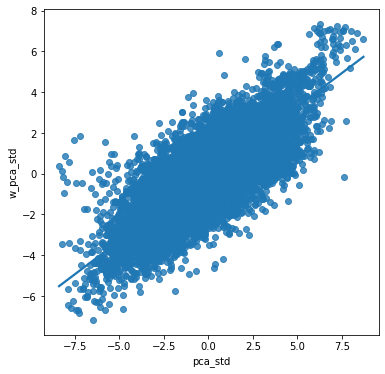

In [ ]:
# Setup the figure and axis to find correlation between spatial deviation and weighted spatial deviation
f, ax = plt.subplots(1, figsize=(6, 6))
# Plot values
seaborn.regplot(
    x='pca_std', y='w_pca_std', data=gdf19, ci=None
);

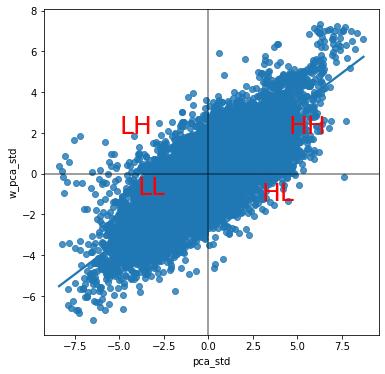

In [ ]:
# Display what each type of category will look like

# Setup the figure and axis
f, ax = plt.subplots(1, figsize=(6, 6))
# Plot values
seaborn.regplot('pca_std', y='w_pca_std', data=gdf19, ci=None
)
# Add vertical and horizontal lines
plt.axvline(0, c='k', alpha=0.5)
plt.axhline(0, c='k', alpha=0.5)
# Add text labels for each quadrant
plt.text(4.5, 2, "HH", fontsize=25, c='r')
plt.text(3, -1.3, "HL", fontsize=25, c='r')
plt.text(-5, 2, "LH", fontsize=25, c='r')
plt.text(-4, -1.0, "LL", fontsize=25, c='r')
# Display
plt.show()

In [ ]:
# Find Moran local spation statistics
lisa = esda.moran.Moran_Local(gdf19['pca_score'], w)

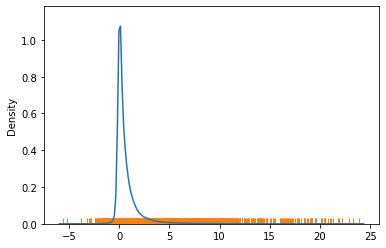

In [ ]:
# Draw KDE line
ax = seaborn.kdeplot(lisa.Is)
# Add one small bar (rug) for each observation
# along horizontal axis
seaborn.rugplot(lisa.Is, ax=ax);

#### 3.G.ii Graphing LISA statisitics

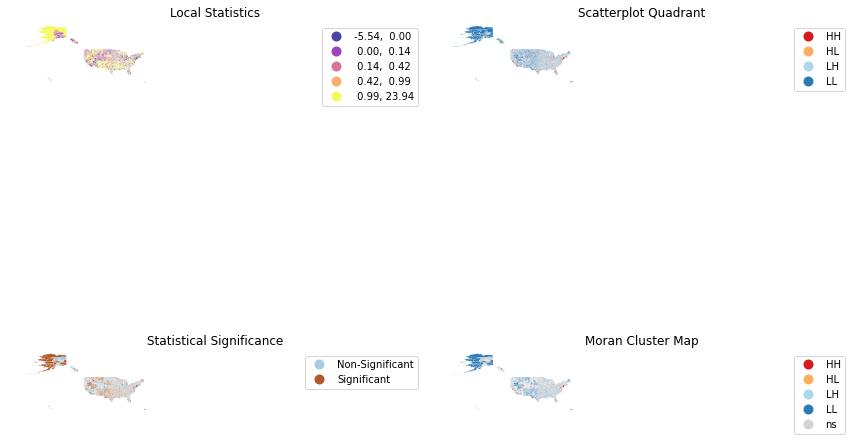

In [ ]:
# Set up figure and axes
f, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))
# Make the axes accessible with single indexing
axs = axs.flatten()

                    # Subplot 1 #
            # Choropleth of local statistics
# Grab first axis in the figure
ax = axs[0]
# Assign new column with local statistics on-the-fly
gdf19.assign(
    Is=lisa.Is
# Plot choropleth of local statistics
).plot(
    column='Is', 
    cmap='plasma', 
    scheme='quantiles',
    k=5, 
    edgecolor='white', 
    linewidth=0.1, 
    alpha=0.75,
    legend=True,
    ax=ax
)

                    # Subplot 2 #
                # Quadrant categories
# Grab second axis of local statistics
ax = axs[1]
# Plot Quandrant colors (note to ensure all polygons are assigned a
# quadrant, we "trick" the function by setting significance level to
# 1 so all observations are treated as "significant" and thus assigned
# a quadrant color
esdaplot.lisa_cluster(lisa, gdf19, p=1, ax=ax);

                    # Subplot 3 #
                # Significance map
# Grab third axis of local statistics
ax = axs[2]
# 
# Find out significant observations
labels = pd.Series(
    1 * (lisa.p_sim < 0.05), # Assign 1 if significant, 0 otherwise
    index=gdf19.index           # Use the index in the original data
# Recode 1 to "Significant and 0 to "Non-significant"
).map({1: 'Significant', 0: 'Non-Significant'})
# Assign labels to `db` on the fly
gdf19.assign(
    cl=labels
# Plot choropleth of (non-)significant areas
).plot(
    column='cl', 
    categorical=True,
    k=2,
    cmap='Paired',
    linewidth=0.1,
    edgecolor='white',
    legend=True,
    ax=ax
)

                       
                    # Subplot 4 #
                    # Cluster map
# Grab second axis of local statistics
ax = axs[3]
# Plot Quandrant colors In this case, we use a 5% significance
# level to select polygons as part of statistically significant
# clusters
esdaplot.lisa_cluster(lisa, gdf19, p=0.05, ax=ax);

                    # Figure styling #
# Set title to each subplot
for i, ax in enumerate(axs.flatten()):
    ax.set_axis_off()
    ax.set_title(
        [
            'Local Statistics', 
            'Scatterplot Quadrant', 
            'Statistical Significance', 
            'Moran Cluster Map'
        ][i], y=0
    )
# Tight layout to minimise in-betwee white space
f.tight_layout()

# Display the figure
plt.show()

#### 3.G.iii Appending to Data Frame

In [ ]:
# Examine counts of different categories
counts = pd.value_counts(lisa.q)
counts

In [ ]:
(lisa.p_sim < 0.05).sum() * 100 / len(lisa.p_sim)

46.87743789776226

In [ ]:
# Assign pseudo P-values to `gdf19`
gdf19['p-sim'] = lisa.p_sim
# `1` if significant (at 5% confidence level), `0` otherwise
sig = 1 * (lisa.p_sim < 0.05)
# Assign significance flag to `db`
gdf19['sig'] = sig
# Print top of the table to inspect
gdf19[['sig','p-sim']].head()

,sig,p-sim
0,1,0.008
1,1,0.007
2,1,0.012
3,1,0.048
4,0,0.133


In [ ]:
# Pick as part of a quadrant only significant polygons, 
# assign `0` otherwise (Non-significant polygons)
spots = lisa.q * sig
# Mapping from value to name (as a dict)
spots_labels = {
    0: 'Non-Significant', 1:'HH', 2: 'LH', 3:'LL', 4: 'HL'
}
# Create column in `db` with labels for each polygon
gdf19['labels'] = pd.Series(
    # First initialise a Series using values and `db` index
    spots, index=gdf19.index
# Then map each value to corresponding label based 
# on the `spots_labels` mapping
).map(spots_labels)
# Print top for inspection
gdf19['labels'].head()

0                 LL
1                 LL
2                 LL
3                 LL
4    Non-Significant
Name: labels, dtype: object

In [ ]:
df_reg['labels'].value_counts()

Non-Significant    38814
HH                 17402
LL                 14927
LH                   963
HL                   959
Name: labels, dtype: int64

In [ ]:
# Create dummy columns
dummy=pd.get_dummies(gdf19['labels'])
gdf19['HH']=dummy['HH']
gdf19['HL']=dummy['HL']
gdf19['LH']=dummy['LH']
gdf19['LL']=dummy['LL']

In [ ]:
# Merge our final result with our most updated dataframe from the last section
df_reg.merge(gdf19[['GEOID_x','HH','HL','LH','LL']], on='GEOID_x')

## Part 4 Identify Target Counties

We can now filter the equity table to exclude HH (They are doing fine), and HL (Weirdly doing fine). This leaves LL, LH, and non-significant (doesn't fit under the other exclusionary conditions).

Then filter to higher than average percent poverty (for whole country), higher than average r_disc (black, hispanic, native), and lower than average log_hhi.

Exclude rural areas and order by density to get the easiest place to put in broadband.

This list shows most excluded areas.

In [ ]:
# Using data found in Equity Analysis, we narrower the equity analyses table to only the factors outlined above

inequ=df_reg.loc[
             (equity_df.HH!=1)&
             (equity_df.HL!=1)&
             (equity_df.percent_poverty>equity_df.percent_poverty.mean())&
             (equity_df.r_disc>equity_df.r_disc.mean())&
             (equity_df.log_hhi<equity_df.log_hhi.mean())&
             (equity_df.pca_score<0)&
             (equity_df.tract_type!='rural')
  ].sort_values('density',ascending=False)

11354

Now lets see how many are left when we filter to only good candidates for broadband expansion

First we edit the categories to find areas where increasing broadband differed most differed from the average, differed most from places that were in Group 5 but had no broadband increase, and places that differed most from places that increased broadband but weren't in Group 5.

In [ ]:
clust.loc[((clust.norm_i5>1.5)|(clust.norm_i5<.5))&
          (np.abs(clust.diff_from_5)>.5)&
          (np.abs(clust.diff_from_increasing_b)>.5)
          ][['norm_i5','diff_from_5','diff_from_increasing_b']]

,norm_i5,diff_from_5,diff_from_increasing_b
asian_nonhispanic,1.864587,0.760843,0.709714
percent_noncitizen,1.533997,-0.728921,0.540996
highschool_or_less,0.153378,-0.717440,-0.529450
home_value_low_quartile,2.210255,1.128473,0.942811
home_value_median,2.223999,1.113735,0.967158
home_value_hi_quartile,2.180468,1.045778,0.929029
median_rent,1.957926,1.015791,0.562527


We can collapse these into four categories: more_than_highschool, percent_noncitizen, home_value_median, and median rent. We exclude asian_nonhispanic because we want the solution to add as little discrimination into the equation as possible, especially towards those groups that already face unequal access (black, hispanic, native).

In [ ]:
# Identify our target tracts based on the analyses of top performing areas that expanded broadband
target_tracts=inequ.loc[(inequ.percent_noncitizen>equity_df.percent_noncitizen.mean())&
          (inequ.home_value_median>equity_df.home_value_median.median())&
          (inequ.median_rent>equity_df.median_rent.median())&
          (inequ.highschool_or_less<equity_df.highschool_or_less.mean())
        ].sort_values('pca_score')

Now we will collapse this into counties to identify the local governments who can work on rectifying the issue

In [ ]:
# Append the status of target tract into a column in the main inequity dataframe

tt=[]
for i in range(len(equity_df)):
  if int(equity_df.iloc[i].GEOID_x) in list(target_tracts.GEOID_x):
    tt.append(1)
  else:
    tt.append(0)

equity_df['tt']=tt
equity_df[['GEOID_x','STATEFP', 'COUNTYFP','tt']]

,GEOID_x,STATEFP,COUNTYFP,tt
0,1055010700,1,55,0
1,1055001300,1,55,0
2,1055000900,1,55,0
3,1055001700,1,55,0
4,1055010501,1,55,0
...,...,...,...,...
73060,72005400900,72,5,0
73061,72127008900,72,127,0
73062,72127009000,72,127,0
73063,72119130702,72,119,0


In [ ]:
# Group to see final counts
equity_df.groupby('tt').agg({'GEOID_x':'count'})

,GEOID_x
tt,
0,72455
1,610


In [ ]:
# Group into counties and count the number of target tracts in each county, along with pca broadband score

county_targ=equity_df.groupby(by=['STATEFP', 'COUNTYFP'],
                  as_index=False).apply(lambda x: pd.Series(dict(
                          target_count=(x.tt).sum(),
                          pca_score=(x.tt*x.pca_score).mean()
                      )))

county_targ=county_targ.sort_values(
    ['target_count','pca_score'],
    ascending=[False,True]
    ).reset_index().drop(columns='index')

county_targ

,STATEFP,COUNTYFP,target_count,pca_score
0,6,37,283.0,-0.090194
1,6,73,39.0,-0.051646
2,6,1,23.0,-0.069572
3,12,86,18.0,-0.034586
4,6,71,18.0,-0.024785
...,...,...,...,...
3212,72,145,0.0,0.000000
3213,72,147,0.0,0.000000
3214,72,149,0.0,0.000000
3215,72,151,0.0,0.000000


In [ ]:
#Generate FIPS county code

county_targ['FIPS']=county_targ.STATEFP*1000+county_targ.COUNTYFP
county_targ

,STATEFP,COUNTYFP,target_count,pca_score,FIPS
0,6,37,283.0,-0.090194,6037
1,6,73,39.0,-0.051646,6073
2,6,1,23.0,-0.069572,6001
3,12,86,18.0,-0.034586,12086
4,6,71,18.0,-0.024785,6071
...,...,...,...,...,...
3212,72,145,0.0,0.000000,72145
3213,72,147,0.0,0.000000,72147
3214,72,149,0.0,0.000000,72149
3215,72,151,0.0,0.000000,72151


In [ ]:
#Merge list of county names onto our sheet using the fips code
target_list=county_name.merge(county_targ,on='FIPS',how='right')[['FIPS','Name','State','target_count','pca_score']]

In [ ]:
# Top 40 counties to work with expanding broadband access as of 2019
target_list.head(40)

,FIPS,Name,State,target_count,pca_score
0,6037,Los Angeles,CA,283.0,-0.090194
1,6073,San Diego,CA,39.0,-0.051646
2,6001,Alameda,CA,23.0,-0.069572
3,12086,Miami-Dade,FL,18.0,-0.034586
4,6071,San Bernardino,CA,18.0,-0.024785
5,36047,Kings,NY,18.0,-0.017785
6,17031,Cook,IL,15.0,-0.006625
7,36005,Bronx,NY,13.0,-0.019034
8,6059,Orange,CA,13.0,-0.010609
9,6053,Monterey,CA,11.0,-0.171034
